# Relation between mutual information and causation

Due to some comments made by Rick, I was triggered in narrowing down the relation between how information theoretical metrics are related to causal relations. In particular how can we deduce from mutual information between a node $s_i$ and the system $S$ that the relation is in fact causal?


An inflated mutual information value could occur when we have a so-called confounder, i.e. where the node could not possible have a causal effect on the system as is found when computing its mutual information.
A study case would be the following graph:


7


/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


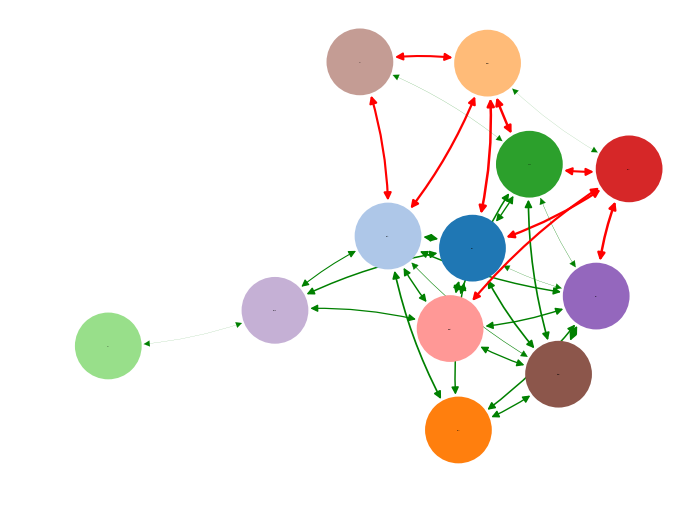

In [5]:
import sys
sys.path.insert(0, '../')
import networkx as nx
from Utils import plotting as plotz, IO
import matplotlib.pyplot as plt, numpy as np
plt.style.use('seaborn-poster')
# graph = nx.path_graph(5)
graph = nx.path_graph(3, nx.DiGraph()) # directed
# graph.add_edges_from([(0,5), (5,6)])
graph = nx.barabasi_albert_graph(20, 2)
graph = nx.krackhardt_kite_graph()

dataDir = 'Psycho' # relative path careful
df    = IO.readCSV(f'../{dataDir}/Graph_min1_1.csv', header = 0, index_col = 0)
h     = IO.readCSV(f'../{dataDir}/External_min1_1.csv', header = 0, index_col = 0)
graph   = nx.from_pandas_adjacency(df)
attr = {}
for node, row in h.iterrows():
    attr[node] = dict(H = row['externalField'], nudges = 0)
nx.set_node_attributes(graph, attr)
pos = {i: np.array(j) * .08 for i, j in nx.nx_agraph.graphviz_layout(graph, prog = 'neato').items()}
fig, ax = plt.subplots()
plotz.addGraphPretty(graph, ax = ax, positions = pos)
ax.axis('off')
fig.show()


## Expectations

The directed graph has one common source node (0). However, as 0 has no edges It should share 0 mutual information with the system as it cannot interact with the system directly; its state is set randomly. Alternatively, one could argue that its information would be contained the longest in the system as node 0 information has the most downstream nodes. This view would imply that node 5 can be similar to node 1 and thus be confounded through 0. 

- $I(s_5^{t + t_0} : S^{t_0})$ is confounded
- or $I(s_0^{t + t_0} : S^{t_0})$ is confounded

# Results

## Magnetization matching
I matched the magnetization to the critical temperature:

100%|██████████| 50/50 [00:00<00:00, 300.93it/s]

Computing mag per t



/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


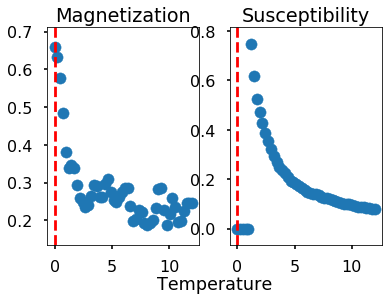

In [2]:
from Toolbox import infcy # montecarlo methods
from Models import fastIsing # models
# match magnetization over temp range
temps        = np.linspace(0, graph.number_of_nodes(), 50)
nSamples     = 100 # int(1e2)

model = fastIsing.Ising(graph)

model.magSide    = 'neg' # equal magnetization sampling
model.updateType = 'single' # ultra smooth when single


mag, sus = model.matchMagnetization(temps, nSamples, burninSamples = 0)

from scipy import ndimage
sus = ndimage.gaussian_filter1d(sus, 1)
mag = ndimage.gaussian_filter1d(mag, 1)
sus[np.isfinite(sus) == 0] = 0 # remove nans
idx     = np.argsort(sus)[-5] # get 'max' idx ; second is used
idx     = (abs(mag - .8)).argmin()
model.t = temps[idx]

# show mag and sus as function of temperature
fig, ax = plt.subplots(1, 2)
ax[0].scatter(temps, mag, label = 'Magnetization')
ax[1].scatter(temps, sus, label = 'Susceptebility')
ax[0].axvline(temps[idx], color = 'red', linestyle = 'dashed')
ax[1].axvline(temps[idx], color = 'red', linestyle = 'dashed')

ax[1].set_title('Susceptibility')
ax[0].set_title('Magnetization')
mainax = fig.add_subplot(111, frameon = False, \
                         xticks = [],\
                         yticks = [], \
                        )
mainax.set_xlabel('Temperature', labelpad = 30)
fig.show()

Temperature at the red dashed line was used. The low on average magnetization is expected due to the directed nature of the graph. It is less stable as nodes choose states more randomly and are less stabilized with the detailed balance condition. 

# Mutual information decay

In [3]:
deltas        = 20             #conditional time steps
nSamples      = int(1e2)       # max number of states
step          = int(1e3)   
burninSamples = 100            # burninSamples + step = sim. steps until sample
repeats       = int(1e3)       # number of conditional repeats

reverse = False
# reverse = True

# added reverse case for 'simulating backwards'
if reverse:
    res = np.zeros((nSamples, model.nNodes))
    rngs= np.random.randint(0, model.nNodes, size = nSamples)
    for i in range(nSamples):
        res[i] = model.updateState(rngs[[i]])
    nWindow = deltas
    ps = {}
    px = np.zeros((nWindow, model.nNodes, model.nStates))
    cpx= {}
    Z  = (nSamples - 1 - nWindow) 

    statemapper = {i : idx for idx, i in enumerate([-1, 1])}

    c = 0
    snapshots = {}
    for i in range(nWindow, nSamples - 1):
        tmp   = res[i-nWindow : i]
        state = tuple(np.array(tmp[-1], dtype = int))
        
        snapshots[state] = snapshots.get(state, 0) + 1 / Z
        c += 1
        ps[state] = ps.get(state, 0) + 1
        if state not in cpx:
            cpx[state] = np.zeros(( nWindow, model.nNodes, model.nStates))
        for t, stateAtTime in enumerate(tmp):
            for node, nodeState in enumerate(stateAtTime):
                px[t, node,   statemapper[nodeState]] += 1 / Z
                cpx[state][t, node, statemapper[nodeState]] += 1 
    c = 0
    rmi = np.zeros((nWindow, model.nNodes))
    for state, val in ps.items():
        cpx[state] /= val
        rmi += np.nansum(cpx[state] * np.log2(cpx[state]), axis = -1) * val / Z
    rmi -= np.nansum(px * np.log2(px), axis = -1)
#     mi  = rmi[::-1,:]
    mi  = rmi
    
# normal supported forward simulation
else:
    snapshots   = infcy.getSnapShots(model, nSamples, step, burninSamples)
    cpx = infcy.monteCarlo(model, snapshots,\
                          deltas, repeats)
    px, rmi = infcy.mutualInformation(cpx, deltas, snapshots, model)
    from Utils.stats import panzeriTrevesCorrection
    bias = panzeriTrevesCorrection(px, cpx, repeats)
    mi = rmi - bias
print(mi.shape)

100%|██████████| 2/2 [00:00<00:00, 188.70it/s]

done
Found 2 states
Delta =  0.03 sec
Decoding..
starting runs
Delta =  0.03 sec
(20, 12)



/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log2
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply


7
(20, 12)


AssertionError: 

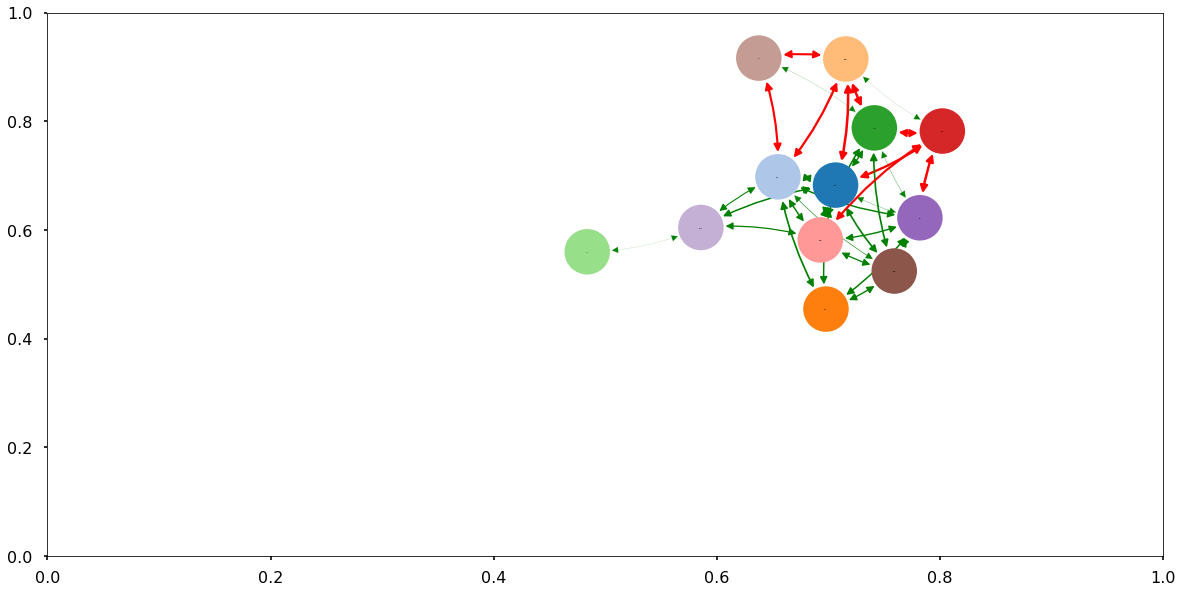

In [8]:
%matplotlib inline
fig, ax = plt.subplots(figsize =(20, 10))
elements = []
x = np.arange(mi.shape[0])
colors = plt.cm.tab20(np.arange(graph.number_of_nodes()))
from mpl_toolkits.axes_grid.inset_locator import inset_axes

inax = inset_axes(ax,
                    width  ="70%", 
                    height ="60%",
                    loc    = 'upper right')
plotz.addGraphPretty(graph, ax = inax, \
                     cmap = colors, mapping = model.mapping, \
                     positions = pos)

inax.axis('off')
for node, nodeidx in sorted(model.mapping.items(), key = lambda x: x[1]):
    ax.plot(x, mi[:, nodeidx], marker ='o', color = colors[nodeidx], label = node)
    element = plt.Line2D([0],[0], \
                       color = colors[nodeidx], \
                       label = node, \
                       linestyle = 'none',\
                       marker = 'o')
    
    elements.append(element)
ax.legend()
ax.set(xlabel = 'Time [step]', \
       ylabel = '$I(s_i^{t + t_0} : S^{t + t_0})$',\
       )
fig.show()

Note some values are overlapping:

In [ ]:
for node, idx in sorted(model.mapping.items(), key = lambda x : x[0]):
    print(f'Node: {node}, first 4 values decay {mi[:4, idx]}')

From these results we see the following ranking:


In [ ]:
func = lambda x, a, b, c, d, e, f, g: a + b * np.exp(-c * (x - d)) + e * np.exp(-f * (x - g)) 
params = dict(maxfev = int(1e6), \
               bounds = (0, np.inf), \
               p0 = np.ones(func.__code__.co_argcount - 1),\
               jac = 'cs',\
             )

                          
coeffs = plotz.fit(mi.T, func = func, params = params)[0]
import scipy
auc = [scipy.integrate.quad(lambda x: func(x, *c), 0, deltas // 2)[0] for c in coeffs]
for rank, idx in enumerate(np.argsort(auc)[::-1]):
    print(f"Rank {rank + 1} -> node {model.rmapping[idx]}, value : {auc[idx]}")

# Interpretation

Directed graphs show information impact in a non-intuitive manner. In undirected graphs information impact can be seen as the amount of information sent, i.e. it can be directly interpreted as a measure of dynamic impact. In the directed graphs, the measure will be the 'reverse', i.e. the amount of information received. Thus the node with the slowest decay rate in directed graphs, will be the one that be the last to receive the information. 

Thus, the MI decay curve above will need to be interpreted with this reverse ranking in mind. Please note that I did think about finding a way to perform nudge dynamics in a reverse way, however I could not find a way where one knows the final state $\delta$ time steps away. 

The results seem show:

- Node 6 has inflated values as it has no downstream nodes but shows similar decay to node 2 which has 2 downstream nodes
- Similarly, node 5 is inflated as it has similar decay to node 1, which has more downstream nodes than 5


# Validation

In order to validate the results, we compute the causal impact through nudging

In [ ]:
nudge  = 2
pulses = {node : nudge for node in model.mapping}
# pulses = {2 : nudge}
pstar = {}

for (node, pulse) in pulses.items():
    print(f"Nudging {node} with {pulse}")
    model.nudges = {node : pulse}
    print(model.nudges.base)
    conditionalstar, p_, mi_ = infcy.runMC(model, snapshots, deltas, repeats)
    pstar[node] = p_


In [ ]:
from Utils import stats
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
elements = []

idx = np.arange(graph.number_of_nodes())
causal_aucs  = np.zeros(graph.number_of_nodes())
for k, v in pstar.items():
    nodeidx = model.mapping[k]
    
#     jdx = [i for i in idx if i != nodeidx]
    jdx = idx
    kl = stats.JS(px, v)
    kl_ = kl[-deltas // 2 + 1:, jdx].sum(-1)
    
    coeff = plotz.fit(kl_[None, :], func, params = params)[0]
    causal_auc = scipy.integrate.quad(lambda x: func(x, *coeff.T), 0, deltas // 2)[0]
    causal_aucs[nodeidx] = causal_auc
    ax[0].plot(kl_, color = colors[nodeidx])
    ax[1].scatter(auc[nodeidx], causal_auc, \
                  color = colors[nodeidx])
    
    ax[0].plot(kl[:, jdx].sum(-1), color = colors[nodeidx])
    
    element = plt.Line2D([0],[0], color = colors[nodeidx], \
                      label = k, \
                      linestyle = 'none',\
                      marker = 'o')
    elements.append(element)
    
    

ax[0].set(xlabel = 'Time[step]',\
         ylabel = 'Jensen-Shannon divergence')
ax[1].set(xlabel = 'information impact', ylabel = 'causal impact')
# ax[1].legend(handles = elements, bbox_to_anchor = (1,1), loc = 'upper left')
width, height = .5, .5
inax = ax[1].inset_axes((1.05, 1-height, width, height), \
                     transform = ax[1].transAxes)
inax.axis('off')
plotz.addGraphPretty(graph, ax = inax, \
                     cmap = colors, mapping = model.mapping, \
                     positions = nx.circular_layout)
ax[1].set_yscale('log'); ax[1].set_xscale('log')
inax.axis('off')
fig.tight_layout()
fig.show()

# Conclusions
- For directed graphs using MI is not reliably due to bias but also reflecting receiving and not necessarily causal impact;
- For undirected graphs MI seems to reflect causal impact well [results not shown].

In [ ]:
fig, ax = plt.subplots(3)
degs = nx.current_flow_betweenness_centrality(graph)
for k, v in dict(degs).items():
    ax[0].scatter(v, auc[model.mapping[k]],  color = colors[model.mapping[k]])
    ax[1].scatter(v, causal_aucs[model.mapping[k]],  color = colors[model.mapping[k]])
    ax[2].scatter(causal_aucs[model.mapping[k]], auc[model.mapping[k]], color = colors[model.mapping[k]])
fig, ax = plt.subplots()
deg = np.fromiter(dict(graph.degree()).values(), dtype = float)
ax.hist(deg, bins = 10)
fig.show()
print(model.mapping, model.adj)